# CSCA-5642: Final Project #
#### Develop an temporal sequence classifier to recognize action from video clips. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-week4/tree/main](https://github.com/alme9155/csca-5642-week4/tree/main)  

<imag src="https://storage.googleapis.com/kaggle-datasets-images/2232355/3733921/1aa7cf2963836e7be0a22c2888d60b87/dataset-cover.jpg?t=2022-06-02-06-19-02" alt="." width="300">

## I. Brief description of the problem and data ##

This project explores the application of deep neural networks for human action recognition (HAR) in video sequences. Human action recognition has a wide range of practical applications, including sports analytics, robotics, and surveillance systems. By leveraging architectures such as CNN+LSTM and 3D Convolutional Networks (C3D), this study aims to compare the effectiveness of different algorithmic designs. Key challenges include modeling long-term temporal dependencies and handling variations in video length, lighting conditions, and resolution.

### Dataset: ####
* The UCF50 dataset is a collection of video clips, such as Baseball pitch, kayaking, diving, etc created by the University of Central Florida, Center for Research in Computer Vision. 
* The UCF50 dataset is a reduced dataset from the original 101 action categories database.
* Ref: [https://www.crcv.ucf.edu/data/UCF101.php](https://www.crcv.ucf.edu/data/UCF101.php).
  
### Data Size and Dimension ####
* Dataset: Total 6999 avi files acrsso 50 categories.
* Each category has an average of 100-170 .avi video files (average ~133 per category).
* Most of the video clips are in the same resolutions (width=320 x height=240 x channel=3)
* Video lengths varies in temporal resolution (frames per second).
* Videos includes various viewpoints, scales, camera motion, and lighting conditions, making it a challenging dataset for action recognition tasks. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

category_counts = {}
input_path = '/kaggle/input/ucf50-latest-version/UCF50/'
for dirname, _, filenames in os.walk(input_path):
    avi_file_count = sum(1 for f in filenames if f.endswith('.avi'))
    
    if avi_file_count > 0:
        category_name = os.path.basename(dirname)
        category_counts[category_name] = avi_file_count

df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', '# AVI Files'])
df_counts = df_counts.sort_values(by='# AVI Files', ascending=False).reset_index(drop=True)
display(df_counts)
print(f"\nTotal .avi file count = {df_counts['# AVI Files'].sum()}")
print(f"Average .avi file count = {df_counts['# AVI Files'].mean()}")


,Category,# AVI Files
0,HorseRiding,197
1,TennisSwing,167
2,Drumming,161
3,BenchPress,160
4,PoleVault,160
5,Punch,160
6,PlayingGuitar,160
7,Kayaking,157
8,SoccerJuggling,156
9,Diving,153



Total .avi file count = 6669
Average .avi file count = 133.38


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [2]:
import os
import cv2
import pandas as pd
from collections import defaultdict


dataset_root = '/kaggle/input/ucf50-latest-version/UCF50/'
video_profile_stats = defaultdict(lambda: {'Video Count': 0, 'Category Count': set()})
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith('.avi'):
            video_path = os.path.join(root, file)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = round(frame_count / fps, 1) if fps > 0 else 0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            resolution = f"{width}x{height}"
            category = os.path.basename(os.path.dirname(video_path))
            #key = (resolution, round(fps, 2), frame_count, duration)
            ret, frame = cap.read()
            channel =1
            if ret and frame is not None and len(frame.shape) == 3:
                channel = frame.shape[2]
            key = (resolution, round(fps, 2), frame_count, duration, channel)
            
            # Accumulate count
            video_profile_stats[key]['Video Count'] += 1
            video_profile_stats[key]['Category Count'].add(category)
            cap.release()

# Convert to DataFrame
summary_rows = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    video_count = stats['Video Count']
    category_count = len(stats['Category Count'])
    summary_rows.append({
        'Resolution': resolution,
        'Frame per sec': fps,
        'Frame Count': frame_count,
        'Duration in sec': duration,
        'Channels': channel,
        'Video Count': video_count,
        'Category Count': category_count
    })

print("\nAccumulated Video Stats Summary:\n")
df_summary = pd.DataFrame(summary_rows).sort_values(by='Video Count', ascending=False).reset_index(drop=True)
display(df_summary)


Accumulated Video Stats Summary:



,Resolution,Frame per sec,Frame Count,Duration in sec,Channels,Video Count,Category Count
0,320x240,25.00,300,12.0,3,275,9
1,320x240,29.97,240,8.0,3,256,7
2,320x240,25.00,250,10.0,3,171,8
3,320x240,29.97,201,6.7,3,101,10
4,320x240,25.00,168,6.7,3,64,15
...,...,...,...,...,...,...,...
827,320x240,29.97,624,20.8,3,1,1
828,320x240,29.97,390,13.0,3,1,1
829,320x240,29.97,447,14.9,3,1,1
830,320x240,29.97,589,19.7,3,1,1


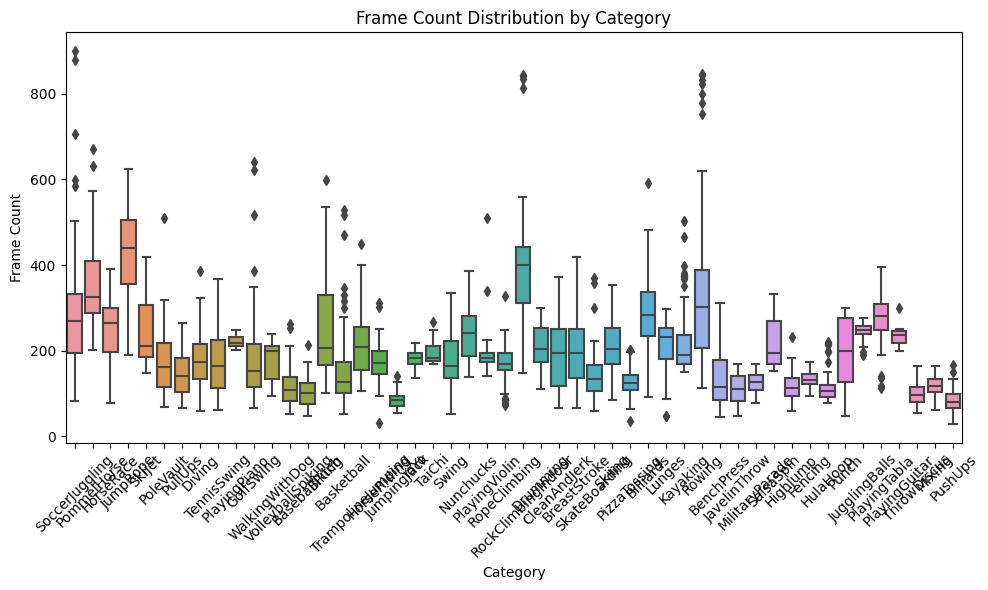

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

category_stats = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    input_shape = f"{frame_count}x{height}x{width}x3"  
    for category in stats['Category Count']:
        category_stats.append({
            'Category': category,
            'Resolution': resolution,
            'Frame per sec': fps,
            'Frame Count': frame_count,
            'Duration in sec': duration,
            'Channels': channel,
            'Input Shape': input_shape,
            'Video Count': stats['Video Count'],  # shared across all category entries here
        })

df_category_stats = pd.DataFrame(category_stats)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_category_stats, x='Category', y='Frame Count')
plt.xticks(rotation=45)
plt.title("Frame Count Distribution by Category")
plt.tight_layout()
plt.show()

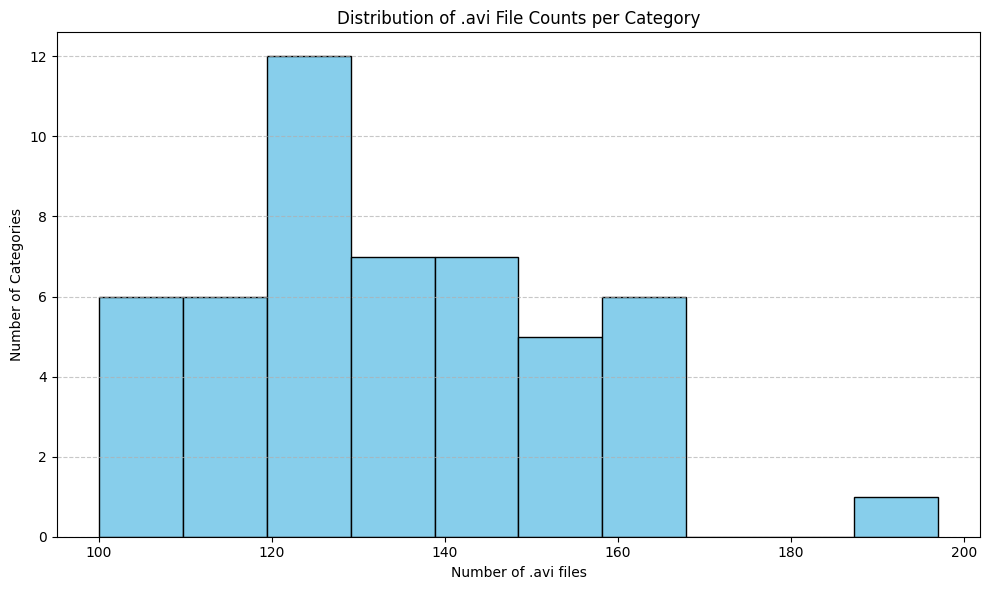

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.hist(df_counts['# AVI Files'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of .avi File Counts per Category')
plt.xlabel('Number of .avi files')
plt.ylabel('Number of Categories')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## III. EDA Summary and Analysis ##

### Summary ###
* The dataset contains ~7,000 .avi video files (exactly 6,669) across 50 action categories.
  * Most categories contain between 110 and 150 video clips.
  * There is no extreme class imbalance in terms of video count per category.
* Almost all of the videos has same spatial size and color format.
  * Width x Height x Channel = 320 x 240 x 3
* There are large variation in frame count.
  * Frame count ranges from 58 to 641.
  * Some categories has total frames > 500-800. (e.g. Jump Rope, Horse Race)
  * Other categories stay under < 150 frames (e.g. Push Ups)
  * Many action categories contain significant outliers in frame count.

### Analysis ###
* Due to the volume of dataset, and the limited GPU quotas on Kaggle platform, **10 video categories** have been selected to reduce the input dataset.
 * 4 selected video categories:
    * **'Basketball', 'PushUps', 'GolfSwing', 'SkateBoarding'**
 * Reducing the input dataset can help reduce training time.

* Even though the input dataset is reduced to less number .avi files to process, data preparation is still required to **standardize video input** shape before applying deep learning model.
* **Spatial Dimension**:
  *  Deep learning model expect fixed input shapes in the form: (Frames × Height × Width × Channels)
  *  The OpenCV library returns images in BGR, but most pre-trained models expect RGB format.
  *  Although the clips are in consistent dimensions (320×240×3), it is best to resize to **112×112×3**
      *  Reducing the spatial dimensions helps lower memory usage and improves processing speed.
      *  Pre-trained models such as R(2+1)D and C3D are designed to operate on 112×112x3 inputs.
* **Temporal Dimension**:
  * Most pre-trained video classifier required fixed-length input in the range of 16-64 frames.
  * Uniform sampling to a **32-frame** clip length provides a good balance for our dataset.
  * For clip <32 frames, clips are padded with the last frame is used to reach the standard length.
  * For clip >32 frames, clips are split into multiple overlapping chunks of the standard length.

* Ref: [https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf](https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)

## IV. Video Files Standardization ##

Prepare video files into uniform format to be consumed by video classification.
* Spatial dimension conversion:
  * Resize avi files dimension from 320(width) x 240(height) to 128 (width)x171(height)
  * Center crop fil to 112(width) x 112(height)
  * ensure files loaded from OpenCV from BGR to RGB format
* Temporal conversion:
  * Clip video files into chunks of 32 frames
* Serialize video chunks into TensorFlow TFRecord files.


In [5]:
# Common constants
BASE_DIR = '/kaggle/input/ucf50-latest-version/UCF50/'
TFRECORD_DIR = '/kaggle/working/ucf50-tfrec'
NUMPY_DIR = '/kaggle/working/ucf50-npy'
# SAMPLE_CATEGORIES = [
#     'HighJump', 'Basketball', 'TennisSwing', 'PullUps', 'PushUps',
#     'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'
# ]
SAMPLE_CATEGORIES = ['Basketball', 'PushUps', 'GolfSwing', 'SkateBoarding']

print(NUMPY_DIR)
print(SAMPLE_CATEGORIES)

/kaggle/working/ucf50-npy
['Basketball', 'PushUps', 'GolfSwing', 'SkateBoarding']


In [6]:
### III.i Data Pre-processing ###
import os
import shutil

def clean_up_output_dir(): 
    if not os.path.exists(NUMPY_DIR):
        os.makedirs(NUMPY_DIR, exist_ok=True)
        print(f"Output directory '{NUMPY_DIR}' created.")
    else:
        for subdir in os.listdir(NUMPY_DIR):
            full_path = os.path.join(NUMPY_DIR, subdir)
            if os.path.isdir(full_path):
                shutil.rmtree(full_path) 
        print(f"All files and subdirectory under '{NUMPY_DIR}' removed.")
        #os.makedirs(NUMPY_DIR, exist_ok=True)
        #print(f"Output directory '{NUMPY_DIR}' re-created.")
    
clean_up_output_dir()
print('Output Clean-up complete')

Output directory '/kaggle/working/ucf50-npy' created.
Output Clean-up complete


In [7]:

import os
import cv2
import numpy as np

# Constants
RESIZE_DIM = (128, 171)   # Resize first to this size
CROP_SIZE = 112           # Then center crop to this
NUM_FRAMES = 32           # Temporal length
STRIDE = 16               # Used for chunking long videos

def standardize_video_with_spatial_conversion(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for _ in range(total_frames):
        success, frame = cap.read()
        if not success:
            break
        frame = cv2.resize(frame, RESIZE_DIM)

        # Center crop manually (corrected redundancy)
        h, w = frame.shape[:2]
        start_h = (h - CROP_SIZE) // 2
        start_w = (w - CROP_SIZE) // 2
        frame = frame[start_h:start_h + CROP_SIZE, start_w:start_w + CROP_SIZE]

        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        frames.append(frame)

    cap.release()
    return frames  # list of (112x112x3) numpy arrays

def standardize_video_with_temporal_conversion(frames):
    chunks = []
    if not frames:
        return [] 
    if len(frames) < NUM_FRAMES:
        # Pad with last frame
        padded = frames + [frames[-1]] * (NUM_FRAMES - len(frames))
        chunks.append(np.array(padded, dtype=np.uint8))
    else:
        # Break into overlapping chunks
        for i in range(0, len(frames) - NUM_FRAMES + 1, STRIDE):
            chunk = frames[i:i + NUM_FRAMES]
            chunks.append(np.array(chunk, dtype=np.uint8))
    return chunks
print('Spatial and Temporal conversion method defined..')

Spatial and Temporal conversion method defined..


In [8]:
import os
import numpy as np
from tqdm import tqdm

def save_as_numpy_example(clip, label, output_dir, category, count):
    sample = {
        'video': clip.astype(np.uint8),  # or np.float32 depending on storage needs
        'label': np.int32(label)
    }
    filename = os.path.join(output_dir, f"{category}_{count:05d}.npy")
    np.save(filename, sample)


def preprocess_videos_to_npy():
    label_map = {cls: idx for idx, cls in enumerate(SAMPLE_CATEGORIES)}
    for category in SAMPLE_CATEGORIES:
        category_path = os.path.join(BASE_DIR, category)
        output_category_dir = os.path.join(NUMPY_DIR, category)  
        os.makedirs(output_category_dir, exist_ok=True)

        count = 0
        for filename in tqdm(os.listdir(category_path), desc=f'Processing {category}'):
            if not filename.endswith('.avi'):
                continue

            video_path = os.path.join(category_path, filename)
            converted_frames = standardize_video_with_spatial_conversion(video_path)
            converted_chunks = standardize_video_with_temporal_conversion(converted_frames)

            for clip in converted_chunks:
                save_as_numpy_example(clip, label_map[category], output_category_dir, category, count)
                count += 1
preprocess_videos_to_npy()
print('video pre-processed and saved as .npy complete.')

Processing SkateBoarding: 100%|██████████| 120/120 [00:05<00:00, 20.73it/s]

video pre-processed and saved as .npy complete.


error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


Category: Basketball, NPY File Count: 983
/kaggle/working/ucf50-npy/Basketball/Basketball_00044.npy


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


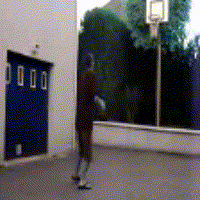

Category: PushUps, NPY File Count: 388
/kaggle/working/ucf50-npy/PushUps/PushUps_00369.npy


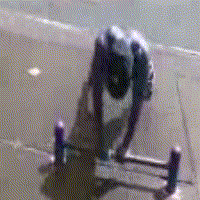

Category: GolfSwing, NPY File Count: 1260
/kaggle/working/ucf50-npy/GolfSwing/GolfSwing_00580.npy


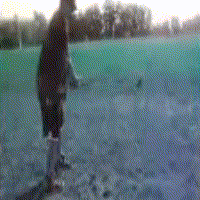

Category: SkateBoarding, NPY File Count: 854
/kaggle/working/ucf50-npy/SkateBoarding/SkateBoarding_00023.npy


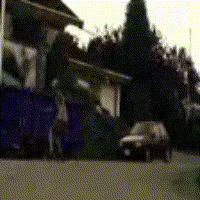

Total .npy video files: 3485.
Display of sample .npy videos complete.


In [9]:
import os
import warnings
import tempfile
import numpy as np
from IPython.display import Image, display
from moviepy.editor import ImageSequenceClip
import random
import cv2

warnings.filterwarnings('ignore')
if 'XDG_RUNTIME_DIR' not in os.environ:
    os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-dir'
    os.makedirs(os.environ['XDG_RUNTIME_DIR'], exist_ok=True)

# Update this with your correct numpy directory and categories
NUMPY_DIR = '/kaggle/working/ucf50-npy'
# SAMPLE_CATEGORIES = ['Basketball', 'PushUps', 'GolfSwing', 'SkateBoarding']


def video_array_to_gif(video_array):
    try:
        with tempfile.NamedTemporaryFile(suffix='.gif', delete=False) as tmp_file:
            gif_filename = tmp_file.name

        if video_array.dtype != np.uint8:
            video_array = np.clip(video_array, 0, 255).astype(np.uint8)
        resized_frames = [cv2.resize(frame, (200, 200)) for frame in video_array]
        clip = ImageSequenceClip(resized_frames, fps=10)
        clip.write_gif(gif_filename, program='ffmpeg', logger=None)
        clip.close()
        return gif_filename

    except Exception as e:
        print(f"GIF creation error: {e}")
        return None



# Loop through each category and show one sample video
total_npy_count = 0
for category in SAMPLE_CATEGORIES:
    category_path = os.path.join(NUMPY_DIR, category)
    if not os.path.isdir(category_path):
        continue

    # Only load video files that end with '_video.npy'
    video_files = [f for f in os.listdir(category_path) if f.endswith('.npy')]
    count = len(video_files)
    total_npy_count += count
    print(f"Category: {category}, NPY File Count: {count}")

    if count > 0:
        sample_video_file = os.path.join(category_path, random.choice(video_files))
        print(sample_video_file)
        data = np.load(sample_video_file, allow_pickle=True).item()
        video_np = data['video'] 

        gif_file = video_array_to_gif(video_np)
        if gif_file and os.path.exists(gif_file):
            display(Image(filename=gif_file))
            os.remove(gif_file)

print(f"Total .npy video files: {total_npy_count}.")
print("Display of sample .npy videos complete.")


## V. Model Architecture ##

### Model Description ###

This model implements 3D Conventional Neural Network for video classification.
- **Input shape**: (batch_size=4, 32, 112, 112, 3)
    - temporal depth 32
    - spatial 112×112 RGB
- **Layers**:
    - Conv3D -> MaxPool3D -> Dropout (×3)
    - Flatten -> Dense(256) -> Dropout -> Dense(10 softmax)
- **Output**:
    - 10 categories
- **(Dropout)**:
    - training=True/False based on call()
- **Batch Size**
    - default batch size is set to 4, which should fit the memory boundary of GPU P100

### Key Design ###
-  Model Init method accept two set of hyper-parameters
    - **filters**: Number of filter in the Convolutional 3D layers
    - **droputs**: Variable Dropout rates 
- Unlike 2D CNN network, 3D Convolutional Neural Network use a cube filter to capture both spatial (Height x Width x Channel) and temporal dimension (**Time**).
- This model accept tensor input of (batch_size x height x width x channel x frames)
- Base Model begins with flat 32 filters on all 3 stacks of Conv3D with dropout rate=0.5
- During hyper-parameter tuning, we will experiment with ascending value of filter [32, 64, 128]
- Then, we will experiment with ascending dropout rate [0.3, 0.4, 0.5]

#### Reference ###
- Ref: [https://www.tensorflow.org/tutorials/video/video_classification](https://www.tensorflow.org/tutorials/video/video_classification)

<img src="https://www.tensorflow.org/images/tutorials/video/3DCNN.png" width="600">

In [10]:
import os
import tensorflow as tf
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')
print(tf.__version__)

2025-07-28 21:54:22.797320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753739662.987770      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753739663.042080      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [11]:
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import tensorflow as tf
import warnings
import keras
from keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')


# During data-preprocessing step, we have limited dataset to 10 categories.
OUTPUT_CLASS = 10

# Custom Conv3D Model Class
class VideoActionClassifier(tf.keras.Model):
    """
    A flexible 3-layer Conv3D-based video classifier.
    Accepts variable filters and dropout rates for hyper-parameter tuning.
    Input shape: (batch, frames, height, width, channels)
    """    
    def __init__(self, filters, dropouts):
        super(VideoActionClassifier, self).__init__()

        self.model_layers = [
            layers.Conv3D(filters[0], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),
            layers.Dropout(dropouts[0]),

            layers.Conv3D(filters[1], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)),
            layers.Dropout(dropouts[1]),

            layers.Conv3D(filters[2], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)),
            layers.Dropout(dropouts[2]),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(OUTPUT_CLASS, activation='softmax')
        ]

    def call(self, x, training=False):
        for layer in self.model_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

# Hyper-parameters
dropout_base_model = [0.3, 0.3, 0.3]
filter_base_model = [32, 32, 32]

# Batch size configuration
BATCH_SIZE = 4  # Safe for 32x112x112x3x8 ~ 80MB RAM, fits P100 GPU

# Base model
base_model = VideoActionClassifier(filters=filter_base_model, 
                                   dropouts=dropout_base_model)
base_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
base_model.build(input_shape=(None, 32, 112, 112, 3))  
base_model.save('conv3d_base_model.h5') 
base_model.summary()  

I0000 00:00:1753739674.603640      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "video_action_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

SPLIT_RATIO = [0.7, 0.15, 0.15]
BATCH_SIZE = 4
SEED = 42
NUMPY_DIR = '/kaggle/working/ucf50-npy'  # Adjust path as needed

# Extract idx from numpy file
def get_all_paths_and_labels():
    paths, labels = [], []
    categories = sorted([d for d in os.listdir(NUMPY_DIR) if os.path.isdir(os.path.join(NUMPY_DIR, d))])
    label_map = {cat: idx for idx, cat in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(NUMPY_DIR, category)
        npy_files = sorted(glob.glob(os.path.join(category_path, '*.npy')))  # <-- SORT HERE

        for file in npy_files:
            paths.append(file)
            labels.append(label_map[category])

    # Sort all file paths and labels together
    sorted_pairs = sorted(zip(paths, labels), key=lambda x: x[0])
    sorted_paths, sorted_labels = zip(*sorted_pairs)
    return list(sorted_paths), list(sorted_labels)

def load_sample(path):
    path = path.numpy().decode('utf-8')
    sample = np.load(path, allow_pickle=True).item()
    return sample['video'], sample['label']

def tf_wrapper(path):
    video, label = tf.py_function(load_sample, [path], [tf.float32, tf.int32])
    video.set_shape([32, 112, 112, 3])
    label.set_shape([])
    return video, label

def make_dataset(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

paths, labels = get_all_paths_and_labels()
train_filepaths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=(1 - SPLIT_RATIO[0]), random_state=SEED, stratify=labels)

validate_filepaths, test_filepaths, validate_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=SPLIT_RATIO[2] / (SPLIT_RATIO[1] + SPLIT_RATIO[2]),
    random_state=SEED, stratify=temp_labels)

train_ds = make_dataset(train_filepaths)
val_ds = make_dataset(validate_filepaths)
test_ds = make_dataset(test_filepaths)

print(f"Train Dataset: {len(train_filepaths)}")
print(f"Validate Dataset: {len(validate_filepaths)}")
print(f"Test Dataset: {len(test_filepaths)}")
print("Dataset loading complete.")


Train Dataset: 2439
Validate Dataset: 523
Test Dataset: 523
Dataset loading complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import tensorflow as tf
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

PATIENCE_VALUE = 5
EPOCHS = 30
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=PATIENCE_VALUE, 
                                     restore_best_weights=True)
checkpoint_base_model = callbacks.ModelCheckpoint('best_model.h5', 
                                                  save_best_only=True, 
                                                  monitor='val_accuracy')

history_base_model = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_base_model]
)

test_loss_base_model, test_acc_base_model = base_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_base_model:.4f}")


Epoch 1/30


I0000 00:00:1753739686.333458   28858 service.cc:148] XLA service 0x7d5f3c00cfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753739686.334178   28858 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753739686.788125   28858 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/610 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.0000e+00 - loss: 297.7929   

I0000 00:00:1753739692.945655   28858 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


610/610 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.4243 - loss: 49.2551 - val_accuracy: 0.6941 - val_loss: 1.0206
Epoch 2/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.6179 - loss: 1.0724 - val_accuracy: 0.8031 - val_loss: 0.7520
Epoch 3/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.7065 - loss: 0.8018 - val_accuracy: 0.7859 - val_loss: 0.7090
Epoch 4/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.7963 - loss: 0.5460 - val_accuracy: 0.8241 - val_loss: 0.5069
Epoch 5/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.8272 - loss: 0.4704 - val_accuracy: 0.7782 - val_loss: 1.0426
Epoch 6/30
211/610 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8080 - loss: 0.4957

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VI. Result Analysis Before Fine-Tuning ##

- Overall, this CNN model performs moderately for the histopathologic cancer detection task before tuning, as it has a simple architecture and achieves 87% accuracy on the validation dataset. 

### Details ###
- At the end, this simplistic CNN model achieves 94% accuracy in the training dataset, but drops accuracy to 87% in the validation set. The drop in accuracy suggested that the model might have overfit the training dataset.
- The curve of training loss starts at 0.4 and decreases steadily to 0.1 around epoch 8. However, validation loss spikes sharply, and this suggest the model is memorizing the training data rather than generalizing it.
- The accuracy curve follows similiar patterns as in the curve of the training loss. Even though there are spikes with the validation curve, the validation accuracy improved gradually.
- Spikes are also observed in the AUC curve, but it did achieve the highest value of 0.97, suggesting the model is highly effective despite fluctuations.


## VIII. Hyper-parameter Fine-Tuning by reducing Number of Filters ##

* **Validation accuracy lower than training accuracy** indicates **overfitting**, where the model performs well on training data but fails to generalize to unseen data.
* Overfitting may result from too many filters that learn noise patterns from the training data.
* Less number of filters encouraging to focus on essential patterns rather than memorizing training data.

- Three set number of filters be used for performance comparison:
  - (16, 32, 64, 128, 256), 
  - (24, 48, 96, 192, 384)
  - (32, 64, 128, 256, 512) (best model architecture)


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

progressive_filters = [32, 64, 128]
progressive_dropouts = [0.3, 0.3, 0.3]


# Tuned filters only
model_filter_tuning = VideoActionClassifier(filters=progressive_filters, 
                                            dropouts=dropout_base_model)
model_filter_tuning.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model_filter_tuning.build(input_shape=(None, 32, 112, 112, 3))  
model_filter_tuning.save('conv3d_model_filter_tuning.h5') 
# model_filter_tuning.summary()  

checkpoint_filter_tuning = callbacks.ModelCheckpoint('conv3d_model_filter_tuning.h5', 
                                       save_best_only=True, monitor='val_accuracy')

history_filter_tuning = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_filter_tuning]
)

test_loss_filter_tuning, test_acc_filter_tuning = model_filter_tuning.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_filter_tuning:.4f}")


In [ ]:

# # Tuned filters only
# model_filter_tuning = VideoActionClassifier(filters=filter_param2, dropouts=dropout_param1)
# model_filter_tuning.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                loss='sparse_categorical_crossentropy',
#                metrics=['accuracy'])

# # Tuned filters and dropouts
# model_filter_dropout_tuning = VideoActionClassifier(filters=filter_param2, dropouts=dropout_param2)
# model_filter_dropout_tuning.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                loss='sparse_categorical_crossentropy',
#                metrics=['accuracy'])

# # parameter tuning model will be built at later stage.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true and predicted labels from test set
y_true_filter_tuning = []
y_pred_filter_tuning = []

for videos, labels in test_ds:
    preds = base_model.predict(videos)
    y_true_filter_tuning.extend(labels.numpy())
    y_pred_filter_tuning.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm_filter_tuning = confusion_matrix(y_true_filter_tuning, y_pred_filter_tuning)
disp_filter_tuning = ConfusionMatrixDisplay(confusion_matrix=cm_filter_tuning)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp_filter_tuning.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


## VI. Explore Different CNN Model Architectures ##

My approach to explore different Convolutional Neural Network (CNN) architectures is as follows:

- Compare CNN model performance of same layout with higher and lower convolution layers
  - **2 convolutional layers**
  - **3 convolutional layers**
  - **5 convolutional layers**


In [ ]:
print('V.')

## VII. Performance Analysis with Different Model Architectures ##

- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required (next performance tuning).

In [ ]:
print('VI')

## XII. Conclusion ##

### Best performance is achieved with the following configurations ###
- Model Architecture: 5 convoluntion block + output block
- Input shape: (96, 96, 3)
- Kernel size=5 for the 1st convolution block, and kernel size=3 for the rest.
- Stride=1, padding=same,
- Each convolution block include batchnormation max pooling size=2, strides=2
- Filter configuration: 32, 64, 128, 256, 512
- Learning rate: default (0.001) with Early stopping


Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Results ###
- High precision and specificity mean the model is reliable with high numbers of TP and TN
- Moderate false negative rate (1,881 missed cases) 


| Metric               | Formula                          | Value     |
|----------------------|----------------------------------|-----------|
| Accuracy             | (TP + TN) / (TP + TN + FP + FN) | 0.9348    |
| Precision (PPV)      | TP / (TP + FP)                  | 0.9489    |
| Recall (Sensitivity) | TP / (TP + FN)                  | 0.8946    |
| Specificity          | TN / (TN + FP)                  | 0.9672    |
| F1 Score             | 2 * (Precision * Recall) / (Precision + Recall) | 0.9209    |

Confusion Matrix:
|                  | Predicted Negative | Predicted Positive | Total   |
|------------------|--------------------|---------------------|---------|
| **Actual Negative** | TN = 25,322 (58.9%) | FP = 860 (2.0%)       | 26,182 (60.9%) |
| **Actual Positive** | FN = 1,881 (4.4%)   | TP = 15,942 (37.1%)    | 17,823 (39.1%) |
| **Total**          | 27,203 (63.2%)     | 16,802 (36.8%)         | 43,005 (100%) |


### What improve the performance of the model ###
- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required.

- Increase filter depth helped feature extraction:
  - The spike in the validation history suggests that the model has learned enough useful features to achieve a high AUC score, but still requires further regularization.
  - Even though fewer filter configurations (24, 48, 96, 192, 384) might have improved regularization, they do not learn enough complex features to exceed the original (32, 64, 128, 256, 512) filter configuration.  -     - Filter configuration (16, 32, 64, 128, 256) performs the worst because it lacks the capacity to capture complex patterns.
  - Thus, for the best model submission, **filter configurations (32, 64, 128, 256, 512) remains the best choice.**

- Early stopping protects against overfitting but requires appropriate learning rates for optimal effect.
  - Learning rate =0.001 (default) achieve the highest accuracy (0.93) and AUC (0.97)
  - When the learning rate is reduced (rate = 0.0005), slower convergence might have caused the model to underfit before early stopping, halting the training.
  - When the learning rate is increased (rate=0.005), faster convergence may cause instability without reaching the optimum.

### What improvement could you try in the future? ###
- More complex convolution model such as VGG-16/ VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore vision transformer(ViT) developed by Google Deep Brain Team [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

## XIII. Future Works and References ##
- Experiment with VGG-16, VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore with Visual Transformer by Google Deep Brain [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

### References ###
- Ref: Tensor flow tutorial [https://www.tensorflow.org/tutorials](https://www.tensorflow.org/tutorials) 
- Ref: TensorFlow Guide: [https://www.tensorflow.org/guide/keras/](https://www.tensorflow.org/guide/keras/)